## New XGBoost Model

Our scikit-learn library must be updated to run VotingRegressor later in the notebook

In [79]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


xgBoost requires separate install as well

In [80]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Import required libraries

In [81]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


In [82]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn.preprocessing import scale

Added the cell below in order to repeat model results

In [83]:
import random
np.random.seed(123)

Read in the gamedatacleanedelo csv to build a model upon. Removing 2020 data per feedback from Dr.G and cancellation of 2020 NCAA Tourney


In [84]:
gamedata = pd.read_csv('~/jupyter/capstone_Group10/data/gamedatacleanedelo.csv')
gamedata = gamedata[gamedata['season']!=2020]
gamedata.rename(columns = {'homeSeasonElo':'hometeam_seasonelo','awaySeasonElo':'awayteam_seasonelo','homedist': 'hometeam_dist', 'awaydist': 'awayteam_dist'}, inplace = True)
print(gamedata.shape)
gamedata.tail()

(16698, 117)


,gamedatekey,season,date,location,winner,awayteam,hometeam,home_points,away_points,home_teamname_season,...,awayteam_steal_percentage,awayteam_strength_of_schedule,awayteam_three_point_attempt_rate,awayteam_two_point_field_goal_percentage,awayteam_win_percentage,awayteam_total_wins,hometeam_dist,awayteam_dist,hometeam_seasonelo,awayteam_seasonelo
16693,2019-04-04-19-texas,2019,"April 4, 2019","Madison Square Garden (IV), New York, New York",Home,LIPSCOMB,TEXAS,81,66,TEXAS_2019,...,9.7,-1.20,0.393,0.549,0.784,29.0,2432.625387,1227.724699,1659.894646,1679.241473
16694,2019-04-05-19-depaul,2019,"April 5, 2019","McGrath-Phillips Arena, Chicago, Illinois",Away,SOUTH_FLORIDA,DEPAUL,65,77,DEPAUL_2019,...,11.3,1.69,0.386,0.491,0.632,24.0,8.173642,1613.240935,1501.036083,1488.835287
16695,2019-04-06-18-virginia,2019,"April 6, 2019","U.S. Bank Stadium, Minneapolis, Minnesota",Home,AUBURN,VIRGINIA,63,62,VIRGINIA_2019,...,13.2,10.92,0.494,0.521,0.750,30.0,1446.437605,1529.611369,1862.279515,1782.506346
16696,2019-04-06-20-michigan-state,2019,"April 6, 2019","U.S. Bank Stadium, Minneapolis, Minnesota",Away,TEXAS_TECH,MICHIGAN_STATE,51,61,MICHIGAN_STATE_2019,...,10.7,9.53,0.360,0.528,0.816,31.0,745.410252,1466.449184,1792.001923,1807.964238
16697,2019-04-08-21-virginia,2019,"April 8, 2019","U.S. Bank Stadium, Minneapolis, Minnesota",Home,TEXAS_TECH,VIRGINIA,85,77,VIRGINIA_2019,...,10.7,9.53,0.360,0.528,0.816,31.0,1446.437605,1466.449184,1862.279515,1807.964238


Getting the data ready for Modeling. 
Creating Neutral site Identifier for games (Neutral means there is no home or away team)

In [85]:
neutral = []
for index,row in gamedata.iterrows():
        dist = row['hometeam_dist']
        if(dist == 0 ):
            #not neutral 
            val = 0.
            neutral.append(val)
        else:
            val = 1.
            neutral.append(val)
            
gamedata['neutral'] = neutral  

Examining which rows have NaN in columns

In [86]:
null_columns=gamedata.columns[gamedata.isnull().any()]
print(gamedata[gamedata.isnull().any(axis=1)][null_columns].head())

                                       location  hometeam_adjem  \
1             Bartow Arena, Birmingham, Alabama           -2.52   
3      Bud Walton Arena, Fayetteville, Arkansas           16.25   
10       Leavey Center, Santa Clara, California           -4.41   
11       Bren Events Center, Irvine, California            1.86   
12  Detrick Gymnasium, New Britain, Connecticut          -20.99   

    hometeam_adj_o  hometeam_adj_d  hometeam_adj_t  hometeam_luck  \
1            103.9           106.4            66.1         -0.008   
3            116.1            99.8            69.7          0.086   
10            97.8           102.2            68.9          0.131   
11           101.8           100.0            66.5         -0.011   
12            93.0           113.9            64.9         -0.023   

    hometeam_sos_adj_em  hometeam_sos_oppo  hometeam_sos_oppd  \
1                 -2.45              103.6              106.0   
3                  8.37              108.6          

Making lists of floats and ints and merging. These are the features we will run the Gridsearch

In [87]:
floats = list(filter(lambda i: gamedata[i].dtypes==np.float64, gamedata.columns))
ints = list(filter(lambda i: gamedata[i].dtypes==np.int64, gamedata.columns))
#merging the lists
columns = ints + floats

In [88]:
columns

['season',
 'home_points',
 'away_points',
 'hometeam_adjem',
 'hometeam_adj_o',
 'hometeam_adj_d',
 'hometeam_adj_t',
 'hometeam_luck',
 'hometeam_sos_adj_em',
 'hometeam_sos_oppo',
 'hometeam_sos_oppd',
 'hometeam_ncsos_adj',
 'hometeam_assist_percentage',
 'hometeam_away_losses',
 'hometeam_away_wins',
 'hometeam_block_percentage',
 'hometeam_conference_losses',
 'hometeam_conference_wins',
 'hometeam_effective_field_goal_percentage',
 'hometeam_field_goal_percentage',
 'hometeam_free_throw_attempt_rate',
 'hometeam_free_throw_percentage',
 'hometeam_free_throws_per_field_goal_attempt',
 'hometeam_home_losses',
 'hometeam_home_wins',
 'hometeam_total_losses',
 'hometeam_net_rating',
 'hometeam_offensive_rating',
 'hometeam_offensive_rebound_percentage',
 'hometeam_opp_assist_percentage',
 'hometeam_opp_block_percentage',
 'hometeam_opp_effective_field_goal_percentage',
 'hometeam_opp_field_goal_percentage',
 'hometeam_opp_free_throw_attempt_rate',
 'hometeam_opp_free_throw_percentag

Creating a new dataframe that will eventually be used for modeling

In [89]:
gamedatacleaned = gamedata[columns] 

Making sure dataframe is correct shape

In [90]:
print(gamedatacleaned.shape) #seeing how the dataframe looks now

(16698, 108)


Removing the target variables that we are predicting

In [91]:
columns.remove('home_points')
columns.remove('away_points')


Create for loop to separate away and home stats

In [92]:
away_cols = [col for col in gamedatacleaned.columns if 'awayteam' in col]
home_cols = [col for col in gamedatacleaned.columns if 'hometeam' in col]

Create home variables and home target variable (home_points)

In [14]:
from sklearn.preprocessing import scale
#getting ready for modeling
X_home = gamedatacleaned[columns] #do all stats
#X = scale(X)
y_home = gamedatacleaned[['home_points']]


In [93]:
X_home.head()

,season,hometeam_adjem,hometeam_adj_o,hometeam_adj_d,hometeam_adj_t,hometeam_luck,hometeam_sos_adj_em,hometeam_sos_oppo,hometeam_sos_oppd,hometeam_ncsos_adj,...,awayteam_strength_of_schedule,awayteam_three_point_attempt_rate,awayteam_two_point_field_goal_percentage,awayteam_win_percentage,awayteam_total_wins,hometeam_dist,awayteam_dist,hometeam_seasonelo,awayteam_seasonelo,neutral
0,2017,13.08,105.3,92.2,65.1,-0.055,7.16,108.1,100.9,-1.64,...,-1.48,0.399,0.484,0.513,20.0,0.0,792.896553,1570.738739,1493.625398,0.0
1,2017,-2.52,103.9,106.4,66.1,-0.008,-2.45,103.6,106.0,0.08,...,-10.28,0.360,0.441,0.219,7.0,0.0,488.414514,NaN,1331.595514,0.0
2,2017,2.81,111.9,109.1,70.0,0.035,6.49,108.6,102.1,-1.06,...,-6.63,0.350,0.557,0.484,15.0,0.0,1627.283096,1502.912248,1500.406512,0.0
3,2017,16.25,116.1,99.8,69.7,0.086,8.37,108.6,100.2,-1.55,...,-3.19,0.412,0.562,0.606,20.0,0.0,966.122690,1623.003916,NaN,0.0
4,2017,8.52,111.9,103.3,73.6,0.045,6.99,107.5,100.5,1.35,...,-1.65,0.415,0.533,0.441,15.0,0.0,458.181115,1565.945257,1437.296807,0.0


#### In a previous model iteration, we decided to remove outliers using an IsolationForest, but it in fact decreased model accuracy. With that said we will forgo this step below.

Examining amount of Features needed in PCA to maximize explained variance with minimal dimensions

In [15]:
from sklearn.preprocessing import RobustScaler
imputer=SimpleImputer(missing_values=np.nan,strategy='median')
imputer=imputer.fit(X_home)
test_X_home = imputer.transform(X_home)
#vectors need to be standardized before PCA to limit variance
#test_X_home = scale(test_X_home)

scaler = StandardScaler()
test_X_home = scaler.fit_transform(test_X_home)

In [16]:
test_X_home = pd.DataFrame(test_X_home)

In [17]:
test_X_home.apply(np.mean)

0      2.608983e-14
1     -1.872313e-17
2      8.102008e-16
3     -6.263738e-16
4      2.900170e-15
           ...     
101   -4.085046e-17
102   -6.170122e-17
103   -2.961659e-16
104    3.625479e-16
105   -4.765887e-17
Length: 106, dtype: float64

No variance as seen by standard deviation of 1 for vectors. Sum of Standard Deviation for Stadardized Vectors should be 106, representing 1 for each vector.

In [18]:
sum(test_X_home.apply(np.std))

106.0

In [19]:
pca = PCA(27)
pca.fit_transform(test_X_home)

results = pd.DataFrame(pca.components_,columns=X_home.columns)
#results

This simulates the output of R's PCA summary function .

In [20]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [21]:
summary = pca_summary(pca,test_X_home,out=True)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,4.760140,0.213763,0.213763
PC2,3.930403,0.145736,0.359500
PC3,2.524659,0.060131,0.419631
PC4,2.305922,0.050163,0.469794
PC5,1.972912,0.036721,0.506515
PC6,1.929443,0.035120,0.541635
PC7,1.732960,0.028332,0.569967
PC8,1.604622,0.024291,0.594257
PC9,1.527603,0.022015,0.616272


In [22]:
summary.head(50)

,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,4.760140,0.213763,0.213763
PC2,3.930403,0.145736,0.359500
PC3,2.524659,0.060131,0.419631
PC4,2.305922,0.050163,0.469794
PC5,1.972912,0.036721,0.506515
PC6,1.929443,0.035120,0.541635
PC7,1.732960,0.028332,0.569967
PC8,1.604622,0.024291,0.594257
PC9,1.527603,0.022015,0.616272


According to Kaisers Criterion we should only retain principal components for which the variance is above 1( on standardized variables). We look for the variance of each of the principal components.

In [23]:
summary['variance'] = summary.sdev**2
summary.head(50)

,sdev,varprop,cumprop,variance
,Standard deviation,Proportion of Variance,Cumulative Proportion,
PC1,4.760140,0.213763,0.213763,22.658931
PC2,3.930403,0.145736,0.359500,15.448066
PC3,2.524659,0.060131,0.419631,6.373903
PC4,2.305922,0.050163,0.469794,5.317274
PC5,1.972912,0.036721,0.506515,3.892383
PC6,1.929443,0.035120,0.541635,3.722750
PC7,1.732960,0.028332,0.569967,3.003149
PC8,1.604622,0.024291,0.594257,2.574810
PC9,1.527603,0.022015,0.616272,2.333571


According to the criterion we would keep 27 Components. 

### Scree Plot

As one moves to the right in the scree plot, toward later components, the variances (or the eigenvalues) drop. It helps us to decide on number of principal components to be retained, although this is subjective.

### explained_variance_ratio_
For a better understanding of the importance of eigenvalues, let’s use them in an example of dimensionality reduction.
If you want to see how much of the total variance is explained by the different components, you can divide each eigenvalue by the total sum of the eigenvalues.


total explained variance ratio 0.8588658132229027


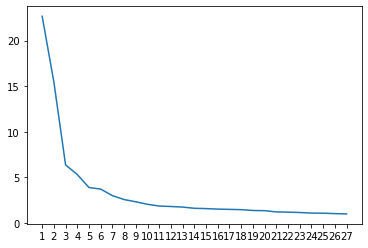

In [24]:
x_ticks = np.arange(len(pca.components_))+1
plt.xticks(x_ticks) # this enforces integers on the x-axis
plt.plot(x_ticks, pca.explained_variance_)
plt.autoscale(enable=True)
print('total explained variance ratio', np.sum(pca.explained_variance_ratio_))

In [25]:
print(pca.explained_variance_ratio_)

[0.2137635  0.14573647 0.06013116 0.05016297 0.0367206  0.03512029
 0.02833158 0.02429061 0.02201481 0.01937575 0.01759427 0.01712641
 0.01653362 0.01527221 0.01496575 0.0144323  0.01415524 0.01385907
 0.01301291 0.01279622 0.01153104 0.01128944 0.01091854 0.0103143
 0.01020076 0.00975793 0.00945807]


### Based on the 'elbow' of our Scree Plot, the explained_variance_ratio_ starts to flatten around 5 PCs. About 23%, 15%, 7%, 6%, and 4% of the total variance within the dataset is explained by the first, second, third, fourth, and fifth components

Based on previous analysis of hyperparameters though, we realized 70 components is optimal

Each coefficient represents the correlation between a particular pair of component and feature.These were summed to gather most important features.

In [26]:
#test_X_home = scaler.fit_transform(test_X_home)
#pca = PCA(n_components=70)
#pca.fit_transform(test_X_home)

#highest correlation between component and feature 
results = pd.DataFrame(pca.components_,columns=X_home.columns).abs().sum(axis=0)
new = pd.DataFrame(results)
new.rename(columns={0:"Value"},inplace=True)
new.reset_index(inplace=True)

In [27]:
new.sort_values(by="Value",ascending=False,inplace=True)
new = new.head(20)

The highest values features in the below visual have the highest correlations coefficient with components in model

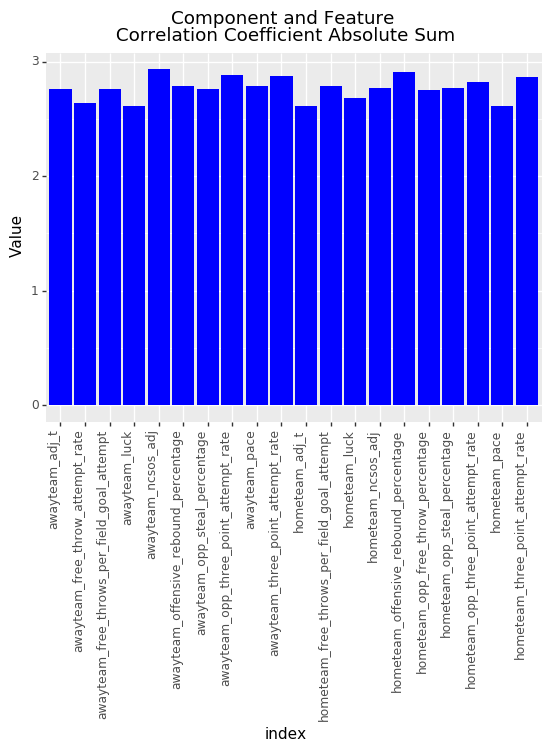

<ggplot: (8733019440602)>

In [28]:
from plotnine import *

# new['Value'] = new['Value'].value_counts().index.tolist()


a = (ggplot(new, aes(x= "index",y="Value")) + 
    geom_bar(stat='identity',fill='blue') + labs(title="Component and Feature \n Correlation Coefficient Absolute Sum "))

a + theme(axis_text_x=element_text(rotation=90, hjust=1))

Home Model

In [29]:
pca = PCA(1)
pca.fit_transform(test_X_home)

results = pd.DataFrame(pca.components_,columns=X_home.columns)
new = pd.DataFrame(results)
new = new.transpose()
new.rename(columns={0:"Value"},inplace=True)
new.reset_index(inplace=True)

In [30]:
#new.sort_values(by="absVal",ascending=False,inplace=True)
new.head(20)

,index,Value
0,season,0.002685
1,hometeam_adjem,0.172938
2,hometeam_adj_o,0.152287
3,hometeam_adj_d,-0.154167
4,hometeam_adj_t,-0.016811
5,hometeam_luck,0.014307
6,hometeam_sos_adj_em,0.135469
7,hometeam_sos_oppo,0.131080
8,hometeam_sos_oppd,-0.130480
9,hometeam_ncsos_adj,0.000006


Since the first component makes up 21 % of the total variance, it represents one of the most important components in our model. We wanted to examine which features have the largest absolute value of correlation coefficient to the first component in our model.

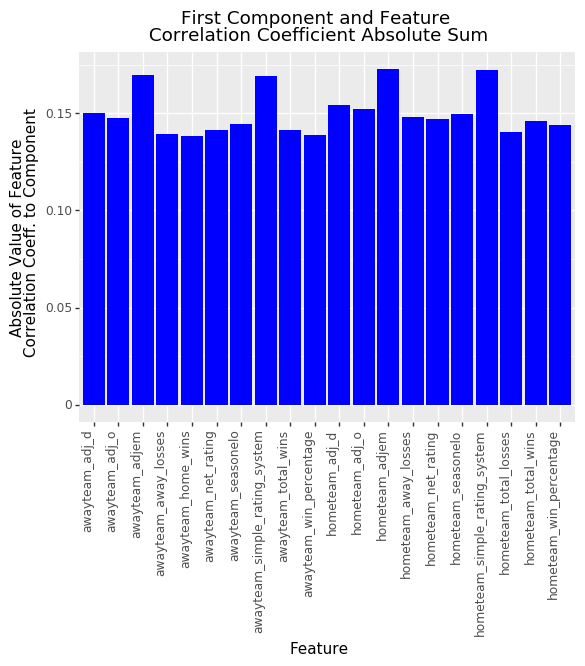

<ggplot: (-9223363303974865811)>

In [31]:
new['absVal'] = new['Value'].abs()
new.sort_values(by="absVal",ascending=False,inplace=True)
new.reset_index(inplace=True)
new = new.head(20)
a = (ggplot(new, aes(x= "index",y="absVal")) + 
    geom_bar(stat='identity',fill='blue') + labs(title="First Component and Feature \n Correlation Coefficient Absolute Sum ",y ="Absolute Value of Feature \n Correlation Coeff. to Component",x="Feature"))

a + theme(axis_text_x=element_text(rotation=90, hjust=1)) 

In [32]:
new

,level_0,index,Value,absVal
0,1,hometeam_adjem,0.172938,0.172938
1,44,hometeam_simple_rating_system,0.172079,0.172079
2,51,awayteam_adjem,0.169516,0.169516
3,94,awayteam_simple_rating_system,0.169198,0.169198
4,3,hometeam_adj_d,-0.154167,0.154167
5,2,hometeam_adj_o,0.152287,0.152287
6,53,awayteam_adj_d,-0.150183,0.150183
7,103,hometeam_seasonelo,0.149525,0.149525
8,11,hometeam_away_losses,-0.147958,0.147958
9,52,awayteam_adj_o,0.147659,0.147659


In [33]:
#ggsave(plot=a, filename='1stPC-EigenvectorDecomp.png', dpi=312,height=7, width=5, units = 'in')

## Pipeline
Our pipeline goes through the following processing:
- Imputation: Fills missing values with default setting (mean)
- Standarization: Standardize features by removing the mean and scaling to unit variance.Necessary step before PCA to limit vectors with large variances to dominate components.
- Dimensionality Reduction: PCA() to reduce dimensions of the dataset. The goal is to reduce dimensions and describe samples as much as possible with fewer variables.
- Voting Regressor: An ensemble method that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction.

The params variable allows for hyperparameters to be tuned within each aspect of the pipeline to ensure model optimization

In [34]:
pipeline = Pipeline([
        #Concatenates results of multiple transformer objects.
    ("imp", SimpleImputer(missing_values=np.nan)),
    #('mmscaler', MinMaxScaler(feature_range=(0, 1))),
    ('sscaler',StandardScaler()),
    ('pca', PCA()),
    ('voting', VotingRegressor(
                estimators=[
                    ("xgb_pip", XGBRegressor()), 
                     ("lr", LinearRegression())                                                    
                                          ]))   
])

params = {
        #imputation params
        'imp__strategy':['median','mean'],

    #PCA hyperparameter tuning
        
        'pca__n_components': [27],
        
    
        #hyperparameters that can be tuned
        'voting__xgb_pip__eta': [0.1], #learning rate, decrease incrementally the learning rate while increasing the number of trees.
        'voting__xgb_pip__max_depth': [4],  #depth of each tree, maximum number of different features used in each tree, increment 1.

    
        #ways to reduce overfitting
        'voting__xgb_pip__min_child_weight': [1], 
        'voting__xgb_pip__gamma': [0], #regularization parameter--1, 5 were used b
        'voting__xgb_pip__subsample': [0.8],#dont take out too many rows, performance will drop otherwise--,0.9, 1.0
                                           #% of rows taken to build the tree
        'voting__xgb_pip__colsample_bytree': [0.3], #number of columns used by each tree
        'voting__xgb_pip__n_estimators': [120], #100
        'voting__xgb_pip__objective': ['count:poisson','reg:squarederror','reg:linear']
 
}

# Home Model

#### The GridSearch below moves throughout the ML pipeline created above using the params object to compare different values of hyperparameters in the model|

In [35]:
X_home.shape

(16698, 106)

In [36]:
# ##10 fold cross validation
homegrid = GridSearchCV(pipeline, cv=10, n_jobs=2, param_grid= params,verbose=5,return_train_score=True)

homegrid.fit(X_home, y_home)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   51.0s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[09:24:23] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('sscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,


best_params_: Parameter setting that gave the best results on the hold out data.



In [37]:
print(homegrid.best_params_)

{'imp__strategy': 'mean', 'pca__n_components': 27, 'voting__xgb_pip__colsample_bytree': 0.3, 'voting__xgb_pip__eta': 0.1, 'voting__xgb_pip__gamma': 0, 'voting__xgb_pip__max_depth': 4, 'voting__xgb_pip__min_child_weight': 1, 'voting__xgb_pip__n_estimators': 120, 'voting__xgb_pip__objective': 'reg:linear', 'voting__xgb_pip__subsample': 0.8}


best_estimator_: shows the estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data

In [38]:
homegrid.best_estimator_

Pipeline(memory=None,
         steps=[('imp',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('sscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=27,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('voting',
                 VotingRegress...
                                                           monotone_constraints=None,
                                                           n_estimators=120,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           objective='reg:line

best_score_: Mean cross-validated score of the best_estimator

In [39]:
homegrid.best_score_

0.37301953493072515

In [40]:
homegrid.cv_results_

{'mean_fit_time': array([1.45313008, 1.61675329, 1.62703624, 1.28363578, 1.50006437,
        1.57461157]),
 'std_fit_time': array([0.01588354, 0.04183074, 0.06938729, 0.0199275 , 0.07041327,
        0.21241314]),
 'mean_score_time': array([0.01323147, 0.01944952, 0.01726248, 0.01085916, 0.01371601,
        0.0156491 ]),
 'std_score_time': array([0.00313823, 0.01147453, 0.00872108, 0.00027147, 0.00031535,
        0.00641261]),
 'param_imp__strategy': masked_array(data=['median', 'median', 'median', 'mean', 'mean', 'mean'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pca__n_components': masked_array(data=[27, 27, 27, 27, 27, 27],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_voting__xgb_pip__colsample_bytree': masked_array(data=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
              mask=[False, False, False, False, False, False],
        fill_

In [41]:
sorted(homegrid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_imp__strategy',
 'param_pca__n_components',
 'param_voting__xgb_pip__colsample_bytree',
 'param_voting__xgb_pip__eta',
 'param_voting__xgb_pip__gamma',
 'param_voting__xgb_pip__max_depth',
 'param_voting__xgb_pip__min_child_weight',
 'param_voting__xgb_pip__n_estimators',
 'param_voting__xgb_pip__objective',
 'param_voting__xgb_pip__subsample',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

## Scoring the model based on accuracy
#### Comparing predicted with actual results
Cells below use the best estimator given by the GridSearch above to predict home team scores

Below cell details accuracy within 10 points

In [42]:
y_pred = homegrid.best_estimator_.predict(X_home)
predictions = [round(value/10) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(round(y_home/10), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.91%


In [43]:
y_pred = homegrid.best_estimator_.predict(X_home)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(round(y_home), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 4.23%


In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_pred = homegrid.best_estimator_.predict(X_home)
predictions = [value for value in y_pred]

rms = sqrt(mean_squared_error(round(y_home), predictions))
print("Root Mean Squared Error:",round(rms,3))

Root Mean Squared Error: 9.365


In [45]:
#saving predictions back into dataframe
gamedata["home_points_pred"] = np.nan
gamedata[['home_points_pred']]= y_pred

# Away Model

In [46]:
#getting ready for modeling
X_away = gamedatacleaned[columns]

y_away = gamedatacleaned[['away_points']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
X_away['home_points_pred'] = y_pred

In [48]:
#testing PCA 
imputer=SimpleImputer(missing_values=np.nan,strategy='median')
imputer=imputer.fit(X_away)
test_X_away = imputer.transform(X_away)


scaler = StandardScaler()
test_X_away = scaler.fit_transform(test_X_away)
test_X_away = pd.DataFrame(test_X_away)


pca = PCA(27)
pca.fit_transform(test_X_away)

results = pd.DataFrame(pca.components_,columns=X_away.columns)

summary = pca_summary(pca,test_X_away,out=True)
summary['variance'] = summary.sdev**2
#summary.head(50)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,4.760146,0.211766,0.211766
PC2,3.974205,0.147610,0.359377
PC3,2.526070,0.059636,0.419012
PC4,2.346558,0.051461,0.470473
PC5,1.991042,0.037049,0.507522
PC6,1.972846,0.036375,0.543897
PC7,1.733334,0.028079,0.571976
PC8,1.604783,0.024068,0.596045
PC9,1.527669,0.021811,0.617856


In [49]:
summary

,sdev,varprop,cumprop,variance
,Standard deviation,Proportion of Variance,Cumulative Proportion,
PC1,4.760146,0.211766,0.211766,22.658988
PC2,3.974205,0.147610,0.359377,15.794301
PC3,2.526070,0.059636,0.419012,6.381032
PC4,2.346558,0.051461,0.470473,5.506336
PC5,1.991042,0.037049,0.507522,3.964248
PC6,1.972846,0.036375,0.543897,3.892120
PC7,1.733334,0.028079,0.571976,3.004447
PC8,1.604783,0.024068,0.596045,2.575328
PC9,1.527669,0.021811,0.617856,2.333773


total explained variance ratio 0.8601405297069679


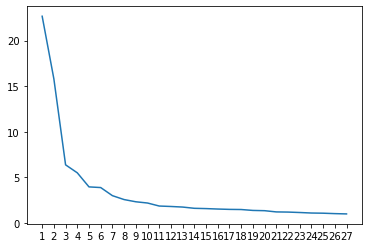

In [50]:
x_ticks = np.arange(len(pca.components_))+1
plt.xticks(x_ticks) # this enforces integers on the x-axis
plt.plot(x_ticks, pca.explained_variance_)
plt.autoscale(enable=True)
print('total explained variance ratio', np.sum(pca.explained_variance_ratio_))

In [51]:
pca = PCA(1)
pca.fit_transform(test_X_away)

results = pd.DataFrame(pca.components_,columns=X_away.columns)
new = pd.DataFrame(results)
new = new.transpose()
new.rename(columns={0:"Value"},inplace=True)
new.reset_index(inplace=True)

In [52]:
new['absVal'] = new['Value'].abs()
new.sort_values(by="absVal",ascending=False,inplace=True)
new.head(20)

,index,Value,absVal
1,hometeam_adjem,0.172868,0.172868
44,hometeam_simple_rating_system,0.172015,0.172015
51,awayteam_adjem,0.169585,0.169585
94,awayteam_simple_rating_system,0.169262,0.169262
3,hometeam_adj_d,-0.154123,0.154123
2,hometeam_adj_o,0.152209,0.152209
53,awayteam_adj_d,-0.150260,0.150260
103,hometeam_seasonelo,0.149452,0.149452
11,hometeam_away_losses,-0.147891,0.147891
52,awayteam_adj_o,0.147704,0.147704


Perform the same GridSearch for the away model to predict away scores

In [53]:
awaygrid = GridSearchCV(pipeline, cv=10, n_jobs=2, param_grid= params,verbose=5,return_train_score=True)

In [54]:
awaygrid.fit(X_away, y_away)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   49.8s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[09:25:19] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('sscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,


best_params_: Parameter setting that gave the best results on the hold out data.



In [55]:
print(awaygrid.best_params_)

{'imp__strategy': 'mean', 'pca__n_components': 27, 'voting__xgb_pip__colsample_bytree': 0.3, 'voting__xgb_pip__eta': 0.1, 'voting__xgb_pip__gamma': 0, 'voting__xgb_pip__max_depth': 4, 'voting__xgb_pip__min_child_weight': 1, 'voting__xgb_pip__n_estimators': 120, 'voting__xgb_pip__objective': 'reg:linear', 'voting__xgb_pip__subsample': 0.8}


best_estimator_: shows the estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data

In [56]:
gamedata["away_points_pred"] = np.nan
gamedata[['away_points_pred']] =awaygrid.best_estimator_.predict(X_away).astype(int)

Below cell details accuracy within 10 points

In [57]:
y_pred = awaygrid.best_estimator_.predict(X_away)
predictions = [round(value/10) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(round(y_away/10), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.33%


Below cell details exact accuracy (not within 10 points)

In [58]:
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(round(y_away), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 4.17%


In [59]:
rms = sqrt(mean_squared_error(round(y_away), predictions))
print("Root Mean Squared Error:",round(rms,3))

Root Mean Squared Error: 9.252


### Margins Model

In [60]:
gamedata['pred_margin'] = abs(gamedata['home_points_pred'] - gamedata['away_points_pred'])
gamedata['margin'] = abs(gamedata['home_points'] - gamedata['away_points'])

In [61]:
gamedata['home_points_pred'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
16693    False
16694    False
16695    False
16696    False
16697    False
Name: home_points_pred, Length: 16698, dtype: bool

In [62]:
margins = gamedata['margin']
pred_marg = gamedata['pred_margin']
predictions = [round(value/10) for value in pred_marg]
# evaluate predictions
accuracy = accuracy_score(round(margins/10), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.03%


In [63]:
margins = gamedata['margin']
pred_marg = gamedata['pred_margin']
predictions = [round(value) for value in pred_marg]
# evaluate predictions
accuracy = accuracy_score(round(margins), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 5.68%


In [64]:
rms = sqrt(mean_squared_error(round(margins), predictions))
print("Root Mean Squared Error:",round(rms,3))

Root Mean Squared Error: 8.683


## Reprint gamedata df to see actual vs. predicted score

In [65]:
#viewing predictions
gamedata[['date','home_teamname_season','home_points','home_points_pred','away_teamname_season', 'away_points','away_points_pred', 'pred_margin','margin']].tail(20)

,date,home_teamname_season,home_points,home_points_pred,away_teamname_season,away_points,away_points_pred,pred_margin,margin
16678,"March 29, 2019",MICHIGAN_STATE_2019,80,79.113204,LOUISIANA_STATE_2019,63,68,11.113204,17
16679,"March 29, 2019",NORTH_CAROLINA_2019,80,81.551368,AUBURN_2019,97,81,0.551368,17
16680,"March 29, 2019",DUKE_2019,75,76.366364,VIRGINIA_TECH_2019,73,66,10.366364,2
16681,"March 29, 2019",KENTUCKY_2019,62,68.955315,HOUSTON_2019,58,64,4.955315,4
16682,"March 30, 2019",GONZAGA_2019,69,71.989935,TEXAS_TECH_2019,75,69,2.989935,6
16683,"March 30, 2019",VIRGINIA_2019,80,65.315070,PURDUE_2019,75,60,5.315070,5
16684,"March 31, 2019",KENTUCKY_2019,71,73.785943,AUBURN_2019,77,71,2.785943,6
16685,"March 31, 2019",DUKE_2019,67,76.909324,MICHIGAN_STATE_2019,68,72,4.909324,1
16686,"April 1, 2019",SOUTH_FLORIDA_2019,63,75.196301,DEPAUL_2019,61,69,6.196301,2
16687,"April 2, 2019",LIPSCOMB_2019,71,75.472257,WICHITA_STATE_2019,64,71,4.472257,7


#### Saving to CSV for future use

In [66]:
#saving to CSV for future use
gamedata.to_csv(r'~/jupyter/capstone_Group10/data/gamedataXGBoostgridpredictionsallpca.csv', index = False)#saving cleaned data to csv for inspection

Pickle model for reuse without running entire notebook

In [67]:
from sklearn.externals import joblib
import pickle

In [68]:
joblib.dump(awaygrid, 'XGBoostawaygridmodelallpca.pkl') 
joblib.dump(homegrid, 'XGBoosthomegridmodelallpca.pkl') 


['XGBoosthomegridmodelallpca.pkl']